<center>
<h1>
NGO FUND RAISING - CLASSIFICATION PROBLEM   
</h1>
</center>


###### Data Prepration- 
    - Exporting data from SAS7BDAT files  
    - Merging Data from Various Files
###### Definition of Target and Outcome Window
###### Data Pre-Processing - 
    - Exploratory Data Analysis - Creating a Funcion to Provide Relevent Descriptive Statistics of each Variable
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy
###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']== 12,8
plt.rcParams['axes.grid']== True
plt.rcParams['patch.force_edgecolor']== True
%matplotlib inline

### Exporting Data from SAS7BDAT files

In [2]:
extrel= pd.read_sas('extrel.sas7bdat', format='SAS7BDAT')

In [3]:
extrelty= pd.read_sas('extrelty.sas7bdat', format='SAS7BDAT')

In [4]:
nameaddr= pd.read_sas('nameaddr.sas7bdat', format='SAS7BDAT')

In [5]:
payhistory= pd.read_sas('payhistory.sas7bdat', format='SAS7BDAT')

In [6]:
communication= pd.read_sas('communication.sas7bdat', format='SAS7BDAT')

In [7]:
commediu= pd.read_sas('commediu.sas7bdat', format='SAS7BDAT')

In [8]:
commaint= pd.read_sas('commaint.sas7bdat', format='SAS7BDAT')

In [9]:
comclas= pd.read_sas('comclas.sas7bdat', format='SAS7BDAT')

In [10]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [11]:
extrel.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,b'0026414',b'CT',1995-02-02,NaT
1,b'0026419',b'FP',1992-03-01,NaT
2,b'0026424',b'FP',1992-03-01,1996-12-24
3,b'0026430',b'FP',1992-03-01,2006-01-31
4,b'0026430',b'CT',1997-03-07,NaT


In [12]:
extrel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26689 entries, 0 to 26688
Data columns (total 4 columns):
EXTRELNO      26689 non-null object
EXRELACTCD    26689 non-null object
EXTRELSTDT    26689 non-null datetime64[ns]
EXRELDATEN    10168 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 834.1+ KB


In [13]:
extrelty.head()

,EXRELACTCD,EXRELACTDE
0,b'FP',b'CommitmentDo'
1,b'PS',b'Prospect'
2,b'PF',b'Prosp Fundra'
3,b'PP',b'Prosp Promot'
4,b'GR',b'Grantor'


In [14]:
dw_df=extrel[(extrel.EXTRELSTDT>='2006-01-01') & (extrel.EXTRELSTDT<='2006-12-31')]
dw_df.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
2624,b'0035969',b'FP',2006-02-01,2007-01-12
2718,b'0036305',b'FP',2006-09-01,NaT
3094,b'0037786',b'FP',2006-03-01,NaT
3316,b'0038595',b'FP',2006-05-01,2007-01-12
4122,b'0152267',b'CT',2006-05-01,NaT


In [15]:
iw_df= extrel[extrel.EXTRELSTDT<='2005-12-03']
iw_df.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,b'0026414',b'CT',1995-02-02,NaT
1,b'0026419',b'FP',1992-03-01,NaT
2,b'0026424',b'FP',1992-03-01,1996-12-24
3,b'0026430',b'FP',1992-03-01,2006-01-31
4,b'0026430',b'CT',1997-03-07,NaT


### Defining a Time Window to Filter Data


The last date available is 02 February 2007. We will observe the dependent variable for a
year.
End of dependent window = 31 December 2006 Start of dependent window = 01 January
2006 -------lag----------- End of independent window = 03 December 2005

In [16]:
base_df= extrel[(extrel.EXRELACTCD== b'FP') & (extrel.EXTRELSTDT< '2005-12-03') & ((extrel.EXRELDATEN>'2006-01-01') | (extrel.EXRELDATEN.isnull()))]

In [17]:
base_df.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
1,b'0026419',b'FP',1992-03-01,NaT
3,b'0026430',b'FP',1992-03-01,2006-01-31
5,b'0026431',b'FP',1992-03-01,NaT
7,b'0026443',b'FP',1992-03-01,NaT
8,b'0026444',b'FP',1992-03-01,NaT


In [18]:
base_df.count()

EXTRELNO      7181
EXRELACTCD    7181
EXTRELSTDT    7181
EXRELDATEN     506
dtype: int64

### 1. Select qualified customers for the basetable
In this case, donors have to be active during the independent period. Given,
Exrelactcd – Activity code of the donor (FP means active) Extrelstdt – Start date of the
relationship Exreldaten – End date of the relationship (Missing: not ended)
So, we define an active customer as one with - activity code = FP, - start date before end of
IW - end date after start of DW [means he was active during IW] or missing [means still a
donor]

In [19]:
start= pd.Timestamp(2006,1,1)
end= pd.Timestamp(2006,12,31)


def churn_chk(x):
    if((x>= start) & (x<=end)):
        return 1
    else:
        return 0
    

In [20]:
base_df['CHURN']= base_df['EXRELDATEN'].apply(lambda x: churn_chk(x))

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
base_df.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN,CHURN
1,b'0026419',b'FP',1992-03-01,NaT,0
3,b'0026430',b'FP',1992-03-01,2006-01-31,1
5,b'0026431',b'FP',1992-03-01,NaT,0
7,b'0026443',b'FP',1992-03-01,NaT,0
8,b'0026444',b'FP',1992-03-01,NaT,0


In [22]:
base_df['CHURN'].value_counts()

0    6707
1     474
Name: CHURN, dtype: int64

In [23]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7181 entries, 1 to 25991
Data columns (total 5 columns):
EXTRELNO      7181 non-null object
EXRELACTCD    7181 non-null object
EXTRELSTDT    7181 non-null datetime64[ns]
EXRELDATEN    506 non-null datetime64[ns]
CHURN         7181 non-null int64
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 336.6+ KB


In [24]:
base_df['STARTYR']= base_df['EXTRELSTDT'].apply(lambda x: x.year)

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
base_df.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN,CHURN,STARTYR
1,b'0026419',b'FP',1992-03-01,NaT,0,1992
3,b'0026430',b'FP',1992-03-01,2006-01-31,1,1992
5,b'0026431',b'FP',1992-03-01,NaT,0,1992
7,b'0026443',b'FP',1992-03-01,NaT,0,1992
8,b'0026444',b'FP',1992-03-01,NaT,0,1992


### Exploring and Merging Data from other tables

In [26]:
communication.head()

,CONTID,MEDIUMCODE,MNTOPCODE,CLASCODE,EXTRELNO,CONTDIREC,CONTDATE
0,b'000405402',b'CI',b'CTS',b'CT',b'0000020',b'O',1994-05-09
1,b'000430904',b'CI',b'CTS',b'CT',b'0000020',b'O',1994-06-14
2,b'000592732',b'CI',b'CTS',b'CT',b'0000020',b'O',1994-10-21
3,b'000593375',b'CI',b'CTS',b'CT',b'0000020',b'O',1994-10-21
4,b'000618514',b'CI',b'CTS',b'CT',b'0000020',b'O',1994-11-28


In [27]:
communication['CONTDIREC'].value_counts().count()

2

In [28]:
communication['MEDIUMCODE'].value_counts().count()

15

In [29]:
communication['MNTOPCODE'].value_counts().count()

24

In [30]:
com_dum= pd.DataFrame()
col_dum= pd.get_dummies(communication['CONTDIREC'], prefix='COMDIREC_', drop_first=True)
com_dum= pd.concat([com_dum, col_dum], axis=1)

col_dum= pd.get_dummies(communication['MEDIUMCODE'], prefix='MEDIUMCODE_', drop_first=True)
com_dum= pd.concat([com_dum, col_dum], axis=1)

col_dum= pd.get_dummies(communication['CLASCODE'], prefix='CLASCODE_', drop_first=True)
com_dum= pd.concat([com_dum, col_dum], axis=1)


com_dum.head()

,COMDIREC__b'O',MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'LE',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'NA',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM'
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [31]:
com_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763569 entries, 0 to 763568
Data columns (total 23 columns):
COMDIREC__b'O'       763569 non-null uint8
MEDIUMCODE__b'AF'    763569 non-null uint8
MEDIUMCODE__b'AM'    763569 non-null uint8
MEDIUMCODE__b'CA'    763569 non-null uint8
MEDIUMCODE__b'CI'    763569 non-null uint8
MEDIUMCODE__b'EM'    763569 non-null uint8
MEDIUMCODE__b'FF'    763569 non-null uint8
MEDIUMCODE__b'FX'    763569 non-null uint8
MEDIUMCODE__b'LE'    763569 non-null uint8
MEDIUMCODE__b'ME'    763569 non-null uint8
MEDIUMCODE__b'MR'    763569 non-null uint8
MEDIUMCODE__b'NA'    763569 non-null uint8
MEDIUMCODE__b'RM'    763569 non-null uint8
MEDIUMCODE__b'TE'    763569 non-null uint8
MEDIUMCODE__b'TM'    763569 non-null uint8
CLASCODE__b'AN'      763569 non-null uint8
CLASCODE__b'CM'      763569 non-null uint8
CLASCODE__b'CT'      763569 non-null uint8
CLASCODE__b'ID'      763569 non-null uint8
CLASCODE__b'NS'      763569 non-null uint8
CLASCODE__b'PM'      763569 n

In [32]:
communication= pd.concat([communication, com_dum], axis=1)
communication.drop(communication[['CONTDIREC','MEDIUMCODE','CLASCODE']], axis=1, inplace= True)
communication.head()

,CONTID,MNTOPCODE,EXTRELNO,CONTDATE,COMDIREC__b'O',MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'LE',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'NA',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM'
0,b'000405402',b'CTS',b'0000020',1994-05-09,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,b'000430904',b'CTS',b'0000020',1994-06-14,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,b'000592732',b'CTS',b'0000020',1994-10-21,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,b'000593375',b'CTS',b'0000020',1994-10-21,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,b'000618514',b'CTS',b'0000020',1994-11-28,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [33]:
communication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763569 entries, 0 to 763568
Data columns (total 27 columns):
CONTID               763569 non-null object
MNTOPCODE            763569 non-null object
EXTRELNO             763569 non-null object
CONTDATE             763569 non-null datetime64[ns]
COMDIREC__b'O'       763569 non-null uint8
MEDIUMCODE__b'AF'    763569 non-null uint8
MEDIUMCODE__b'AM'    763569 non-null uint8
MEDIUMCODE__b'CA'    763569 non-null uint8
MEDIUMCODE__b'CI'    763569 non-null uint8
MEDIUMCODE__b'EM'    763569 non-null uint8
MEDIUMCODE__b'FF'    763569 non-null uint8
MEDIUMCODE__b'FX'    763569 non-null uint8
MEDIUMCODE__b'LE'    763569 non-null uint8
MEDIUMCODE__b'ME'    763569 non-null uint8
MEDIUMCODE__b'MR'    763569 non-null uint8
MEDIUMCODE__b'NA'    763569 non-null uint8
MEDIUMCODE__b'RM'    763569 non-null uint8
MEDIUMCODE__b'TE'    763569 non-null uint8
MEDIUMCODE__b'TM'    763569 non-null uint8
CLASCODE__b'AN'      763569 non-null uint8
CLASCODE__b'CM'  

In [34]:
lst_com= communication.groupby('EXTRELNO').max()
lst_com.drop(lst_com[['CONTID','MNTOPCODE']], axis=1, inplace=True)
lst_com.head()

,CONTDATE,COMDIREC__b'O',MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'LE',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'NA',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM'
EXTRELNO,,,,,,,,,,,,,,,,,,,,,,,,
b'0000020',2006-08-10,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0
b'0000035',2006-10-03,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0
b'0000042',2001-03-29,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,1
b'0000043',2004-01-23,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,1,0,1,1,0,1,1,0
b'0000060',2000-02-12,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0


In [35]:
lst_com.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21932 entries, b'0000020' to b'0245048'
Data columns (total 24 columns):
CONTDATE             21932 non-null datetime64[ns]
COMDIREC__b'O'       21932 non-null uint8
MEDIUMCODE__b'AF'    21932 non-null uint8
MEDIUMCODE__b'AM'    21932 non-null uint8
MEDIUMCODE__b'CA'    21932 non-null uint8
MEDIUMCODE__b'CI'    21932 non-null uint8
MEDIUMCODE__b'EM'    21932 non-null uint8
MEDIUMCODE__b'FF'    21932 non-null uint8
MEDIUMCODE__b'FX'    21932 non-null uint8
MEDIUMCODE__b'LE'    21932 non-null uint8
MEDIUMCODE__b'ME'    21932 non-null uint8
MEDIUMCODE__b'MR'    21932 non-null uint8
MEDIUMCODE__b'NA'    21932 non-null uint8
MEDIUMCODE__b'RM'    21932 non-null uint8
MEDIUMCODE__b'TE'    21932 non-null uint8
MEDIUMCODE__b'TM'    21932 non-null uint8
CLASCODE__b'AN'      21932 non-null uint8
CLASCODE__b'CM'      21932 non-null uint8
CLASCODE__b'CT'      21932 non-null uint8
CLASCODE__b'ID'      21932 non-null uint8
CLASCODE__b'NS'      21932 non-nu

In [36]:
payhistory.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38.0,1993-12-31,9.57,b'0000019',b'X',b'CO'
1,39.0,1993-12-31,41.32,b'0000020',b'X',b'CO'
2,40.0,1993-12-31,13.10,b'0000020',b'X',b'CO'
3,54091.0,1994-01-01,2.02,b'0000020',b'X',b'CO'
4,104480.0,1994-05-19,0.50,b'0000020',b'D',b'OK'


In [37]:
payhistory['STATUS'].value_counts()

b'OK'    1149504
b'CO'      47500
b'RC'       8560
b'RF'        155
Name: STATUS, dtype: int64

In [38]:
pay_dum= pd.DataFrame()
col_dum1= pd.get_dummies(payhistory['PAYTYPECD'], prefix='PAYTYPECD_', drop_first=True)
pay_dum= pd.concat([pay_dum, col_dum1], axis=1)

col_dum1= pd.get_dummies(payhistory['STATUS'], prefix='PAYSTATUS_', drop_first=True)
pay_dum= pd.concat([pay_dum, col_dum1], axis=1)

pay_dum.head()

,PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF'
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,0,1,0,0


In [39]:
payhistory= pd.concat([payhistory, pay_dum], axis=1)
payhistory.drop(payhistory[['PAYTYPECD','STATUS']], axis=1, inplace=True)
payhistory.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF'
0,38.0,1993-12-31,9.57,b'0000019',0,0,1,0,0,0
1,39.0,1993-12-31,41.32,b'0000020',0,0,1,0,0,0
2,40.0,1993-12-31,13.10,b'0000020',0,0,1,0,0,0
3,54091.0,1994-01-01,2.02,b'0000020',0,0,1,0,0,0
4,104480.0,1994-05-19,0.50,b'0000020',0,0,0,1,0,0


In [40]:
payhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205720 entries, 0 to 1205719
Data columns (total 10 columns):
PID                 1205720 non-null float64
PDATE               1205720 non-null datetime64[ns]
PAMT                1205720 non-null float64
EXTRELNO            1205720 non-null object
PAYTYPECD__b'E'     1205720 non-null uint8
PAYTYPECD__b'O'     1205720 non-null uint8
PAYTYPECD__b'X'     1205720 non-null uint8
PAYSTATUS__b'OK'    1205720 non-null uint8
PAYSTATUS__b'RC'    1205720 non-null uint8
PAYSTATUS__b'RF'    1205720 non-null uint8
dtypes: datetime64[ns](1), float64(2), object(1), uint8(6)
memory usage: 43.7+ MB


In [41]:
pay_history= payhistory.set_index('EXTRELNO')
pay_history= pay_history.groupby(pay_history.index).max()
pay_history.head()

,PID,PDATE,PAMT,PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF'
EXTRELNO,,,,,,,,,
b'0000019',38.0,1993-12-31,9.57,0,0,1,0,0,0
b'0000020',5080067.0,2007-01-17,41.32,0,0,1,1,0,0
b'0000035',5080071.0,2007-01-17,45.85,0,0,1,1,0,0
b'0000042',2735962.0,2001-01-23,52.41,0,0,1,1,1,0
b'0000043',3783934.0,2003-07-14,53.92,0,0,1,1,0,0


In [42]:
pay_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16308 entries, b'0000019' to b'0244875'
Data columns (total 9 columns):
PID                 16308 non-null float64
PDATE               16308 non-null datetime64[ns]
PAMT                16308 non-null float64
PAYTYPECD__b'E'     16308 non-null uint8
PAYTYPECD__b'O'     16308 non-null uint8
PAYTYPECD__b'X'     16308 non-null uint8
PAYSTATUS__b'OK'    16308 non-null uint8
PAYSTATUS__b'RC'    16308 non-null uint8
PAYSTATUS__b'RF'    16308 non-null uint8
dtypes: datetime64[ns](1), float64(2), uint8(6)
memory usage: 605.2+ KB


### Creating RFM Variables (Recency, Frequency and Monetary values) for the Model

In [43]:
pay= payhistory.groupby(['EXTRELNO']).PAMT.agg(['sum'])
pay= pay.rename(columns= {'sum': 'TOTAL_REVENUE'})
pay['PAYLST']= payhistory.groupby(['EXTRELNO']).PDATE.max()
pay['FREQUENCY']= payhistory.groupby(['EXTRELNO']).size()

pay.head()

,TOTAL_REVENUE,PAYLST,FREQUENCY
EXTRELNO,,,
b'0000019',9.57,1993-12-31,1
b'0000020',3176.97,2007-01-17,158
b'0000035',3168.40,2007-01-17,155
b'0000042',1543.03,2001-01-23,85
b'0000043',4373.24,2003-07-14,229


In [44]:
pay.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16308 entries, b'0000019' to b'0244875'
Data columns (total 3 columns):
TOTAL_REVENUE    16308 non-null float64
PAYLST           16308 non-null datetime64[ns]
FREQUENCY        16308 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 509.6+ KB


In [45]:
pay_history= pd.concat([pay_history,pay], axis=1)
pay_history.drop(pay_history[['PID','PDATE','PAMT']], axis=1, inplace=True)
pay_history.head()

,PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF',TOTAL_REVENUE,PAYLST,FREQUENCY
EXTRELNO,,,,,,,,,
b'0000019',0,0,1,0,0,0,9.57,1993-12-31,1
b'0000020',0,0,1,1,0,0,3176.97,2007-01-17,158
b'0000035',0,0,1,1,0,0,3168.40,2007-01-17,155
b'0000042',0,0,1,1,1,0,1543.03,2001-01-23,85
b'0000043',0,0,1,1,0,0,4373.24,2003-07-14,229


In [46]:
pay_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16308 entries, b'0000019' to b'0244875'
Data columns (total 9 columns):
PAYTYPECD__b'E'     16308 non-null uint8
PAYTYPECD__b'O'     16308 non-null uint8
PAYTYPECD__b'X'     16308 non-null uint8
PAYSTATUS__b'OK'    16308 non-null uint8
PAYSTATUS__b'RC'    16308 non-null uint8
PAYSTATUS__b'RF'    16308 non-null uint8
TOTAL_REVENUE       16308 non-null float64
PAYLST              16308 non-null datetime64[ns]
FREQUENCY           16308 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), uint8(6)
memory usage: 605.2+ KB


In [47]:
lst_com.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21932 entries, b'0000020' to b'0245048'
Data columns (total 24 columns):
CONTDATE             21932 non-null datetime64[ns]
COMDIREC__b'O'       21932 non-null uint8
MEDIUMCODE__b'AF'    21932 non-null uint8
MEDIUMCODE__b'AM'    21932 non-null uint8
MEDIUMCODE__b'CA'    21932 non-null uint8
MEDIUMCODE__b'CI'    21932 non-null uint8
MEDIUMCODE__b'EM'    21932 non-null uint8
MEDIUMCODE__b'FF'    21932 non-null uint8
MEDIUMCODE__b'FX'    21932 non-null uint8
MEDIUMCODE__b'LE'    21932 non-null uint8
MEDIUMCODE__b'ME'    21932 non-null uint8
MEDIUMCODE__b'MR'    21932 non-null uint8
MEDIUMCODE__b'NA'    21932 non-null uint8
MEDIUMCODE__b'RM'    21932 non-null uint8
MEDIUMCODE__b'TE'    21932 non-null uint8
MEDIUMCODE__b'TM'    21932 non-null uint8
CLASCODE__b'AN'      21932 non-null uint8
CLASCODE__b'CM'      21932 non-null uint8
CLASCODE__b'CT'      21932 non-null uint8
CLASCODE__b'ID'      21932 non-null uint8
CLASCODE__b'NS'      21932 non-nu

In [48]:
pay_com= pd.concat([lst_com, pay_history], axis=1, join= 'inner')
pay_com.head()

,CONTDATE,COMDIREC__b'O',MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'LE',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'NA',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM',PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF',TOTAL_REVENUE,PAYLST,FREQUENCY
EXTRELNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b'0000020',2006-08-10,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,3176.97,2007-01-17,158
b'0000035',2006-10-03,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,3168.40,2007-01-17,155
b'0000042',2001-03-29,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,1,1,0,1543.03,2001-01-23,85
b'0000043',2004-01-23,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,1,0,1,1,0,1,1,0,0,0,1,1,0,0,4373.24,2003-07-14,229
b'0000060',2000-02-12,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1,1,0,0,1333.33,1999-12-07,76


In [49]:
pay_com.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15321 entries, b'0000020' to b'0244875'
Data columns (total 33 columns):
CONTDATE             15321 non-null datetime64[ns]
COMDIREC__b'O'       15321 non-null uint8
MEDIUMCODE__b'AF'    15321 non-null uint8
MEDIUMCODE__b'AM'    15321 non-null uint8
MEDIUMCODE__b'CA'    15321 non-null uint8
MEDIUMCODE__b'CI'    15321 non-null uint8
MEDIUMCODE__b'EM'    15321 non-null uint8
MEDIUMCODE__b'FF'    15321 non-null uint8
MEDIUMCODE__b'FX'    15321 non-null uint8
MEDIUMCODE__b'LE'    15321 non-null uint8
MEDIUMCODE__b'ME'    15321 non-null uint8
MEDIUMCODE__b'MR'    15321 non-null uint8
MEDIUMCODE__b'NA'    15321 non-null uint8
MEDIUMCODE__b'RM'    15321 non-null uint8
MEDIUMCODE__b'TE'    15321 non-null uint8
MEDIUMCODE__b'TM'    15321 non-null uint8
CLASCODE__b'AN'      15321 non-null uint8
CLASCODE__b'CM'      15321 non-null uint8
CLASCODE__b'CT'      15321 non-null uint8
CLASCODE__b'ID'      15321 non-null uint8
CLASCODE__b'NS'      15321 non-nu

In [50]:
base1= base_df.set_index('EXTRELNO')
final= pd.concat([base1, pay_com], axis=1, join='inner')
final.head()

,EXRELACTCD,EXTRELSTDT,EXRELDATEN,CHURN,STARTYR,CONTDATE,COMDIREC__b'O',MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'LE',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'NA',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM',PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF',TOTAL_REVENUE,PAYLST,FREQUENCY
EXTRELNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b'0026419',b'FP',1992-03-01,NaT,0,1992,2006-07-19,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,3155.05,2007-01-02,69
b'0026430',b'FP',1992-03-01,2006-01-31,1,1992,2006-03-16,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,1,1,1,0,1,1,0,0,1,1,1,1,0,2786.13,2005-10-18,146
b'0026431',b'FP',1992-03-01,NaT,0,1992,2006-10-05,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,3050.61,2006-04-28,21
b'0026443',b'FP',1992-03-01,NaT,0,1992,2006-12-14,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,1,1,1,0,3109.62,2007-01-17,156
b'0026444',b'FP',1992-03-01,NaT,0,1992,2006-06-21,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,3092.47,2007-01-17,157


In [51]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7164 entries, b'0026419' to b'0240937'
Data columns (total 38 columns):
EXRELACTCD           7164 non-null object
EXTRELSTDT           7164 non-null datetime64[ns]
EXRELDATEN           494 non-null datetime64[ns]
CHURN                7164 non-null int64
STARTYR              7164 non-null int64
CONTDATE             7164 non-null datetime64[ns]
COMDIREC__b'O'       7164 non-null uint8
MEDIUMCODE__b'AF'    7164 non-null uint8
MEDIUMCODE__b'AM'    7164 non-null uint8
MEDIUMCODE__b'CA'    7164 non-null uint8
MEDIUMCODE__b'CI'    7164 non-null uint8
MEDIUMCODE__b'EM'    7164 non-null uint8
MEDIUMCODE__b'FF'    7164 non-null uint8
MEDIUMCODE__b'FX'    7164 non-null uint8
MEDIUMCODE__b'LE'    7164 non-null uint8
MEDIUMCODE__b'ME'    7164 non-null uint8
MEDIUMCODE__b'MR'    7164 non-null uint8
MEDIUMCODE__b'NA'    7164 non-null uint8
MEDIUMCODE__b'RM'    7164 non-null uint8
MEDIUMCODE__b'TE'    7164 non-null uint8
MEDIUMCODE__b'TM'    7164 non-null u

In [52]:
final['PAYLST'].isnull().sum()

0

In [53]:
def recency(x):
    n= datetime.datetime(2007,2,2)
    y= n - x
    return y.days

### Determining Length of Relationship For Each Donor

In [55]:
final['RECENCY']= final['PAYLST'].apply(lambda x: recency(x))
final['RELATION_LEN']= final['EXRELDATEN'] - final['EXTRELSTDT']
final['RELATION_LEN']= final['RELATION_LEN'].apply(lambda x: x.days) 
final.head()

,EXRELACTCD,EXTRELSTDT,EXRELDATEN,CHURN,STARTYR,CONTDATE,COMDIREC__b'O',MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'LE',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'NA',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM',PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF',TOTAL_REVENUE,PAYLST,FREQUENCY,RECENCY,RELATION_LEN
EXTRELNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b'0026419',b'FP',1992-03-01,NaT,0,1992,2006-07-19,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,3155.05,2007-01-02,69,31,NaN
b'0026430',b'FP',1992-03-01,2006-01-31,1,1992,2006-03-16,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,1,1,1,0,1,1,0,0,1,1,1,1,0,2786.13,2005-10-18,146,472,5084.0
b'0026431',b'FP',1992-03-01,NaT,0,1992,2006-10-05,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,3050.61,2006-04-28,21,280,NaN
b'0026443',b'FP',1992-03-01,NaT,0,1992,2006-12-14,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,1,1,1,0,3109.62,2007-01-17,156,16,NaN
b'0026444',b'FP',1992-03-01,NaT,0,1992,2006-06-21,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,3092.47,2007-01-17,157,16,NaN


In [56]:
import datetime
#final[final['RELATION_LEN'].isnull()]['RELATION_LEN']= final['EXTRELSTDT'].apply(lambda x: datetime.datetime(2007,2,2) - x )
final['RELATION_LEN'].fillna(datetime.datetime(2007,2,2) - final.EXTRELSTDT, inplace= True)
final['RELATION_LEN']=final['RELATION_LEN'].apply(lambda x: round(x,1))
final.head()

,EXRELACTCD,EXTRELSTDT,EXRELDATEN,CHURN,STARTYR,CONTDATE,COMDIREC__b'O',MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'LE',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'NA',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM',PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF',TOTAL_REVENUE,PAYLST,FREQUENCY,RECENCY,RELATION_LEN
EXTRELNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b'0026419',b'FP',1992-03-01,NaT,0,1992,2006-07-19,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,3155.05,2007-01-02,69,31,4.709664e+17
b'0026430',b'FP',1992-03-01,2006-01-31,1,1992,2006-03-16,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,1,1,1,0,1,1,0,0,1,1,1,1,0,2786.13,2005-10-18,146,472,5.084000e+03
b'0026431',b'FP',1992-03-01,NaT,0,1992,2006-10-05,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,3050.61,2006-04-28,21,280,4.709664e+17
b'0026443',b'FP',1992-03-01,NaT,0,1992,2006-12-14,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,1,1,1,0,3109.62,2007-01-17,156,16,4.709664e+17
b'0026444',b'FP',1992-03-01,NaT,0,1992,2006-06-21,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,3092.47,2007-01-17,157,16,4.709664e+17


In [57]:
#final.to_csv('final_dataset.csv')

In [58]:
#final= pd.read_csv('final_dataset.csv', index_col= 'EXTRELNO')
#final.head()

In [59]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7164 entries, b'0026419' to b'0240937'
Data columns (total 40 columns):
EXRELACTCD           7164 non-null object
EXTRELSTDT           7164 non-null datetime64[ns]
EXRELDATEN           494 non-null datetime64[ns]
CHURN                7164 non-null int64
STARTYR              7164 non-null int64
CONTDATE             7164 non-null datetime64[ns]
COMDIREC__b'O'       7164 non-null uint8
MEDIUMCODE__b'AF'    7164 non-null uint8
MEDIUMCODE__b'AM'    7164 non-null uint8
MEDIUMCODE__b'CA'    7164 non-null uint8
MEDIUMCODE__b'CI'    7164 non-null uint8
MEDIUMCODE__b'EM'    7164 non-null uint8
MEDIUMCODE__b'FF'    7164 non-null uint8
MEDIUMCODE__b'FX'    7164 non-null uint8
MEDIUMCODE__b'LE'    7164 non-null uint8
MEDIUMCODE__b'ME'    7164 non-null uint8
MEDIUMCODE__b'MR'    7164 non-null uint8
MEDIUMCODE__b'NA'    7164 non-null uint8
MEDIUMCODE__b'RM'    7164 non-null uint8
MEDIUMCODE__b'TE'    7164 non-null uint8
MEDIUMCODE__b'TM'    7164 non-null u

In [60]:
final.drop(final[['EXRELACTCD', 'EXTRELSTDT', 'EXRELDATEN','CONTDATE','PAYLST']], axis=1, inplace= True)

In [61]:
final.head()

,CHURN,STARTYR,COMDIREC__b'O',MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'LE',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'NA',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM',PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF',TOTAL_REVENUE,FREQUENCY,RECENCY,RELATION_LEN
EXTRELNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b'0026419',0,1992,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,3155.05,69,31,4.709664e+17
b'0026430',1,1992,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,1,1,1,0,1,1,0,0,1,1,1,1,0,2786.13,146,472,5.084000e+03
b'0026431',0,1992,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,3050.61,21,280,4.709664e+17
b'0026443',0,1992,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,1,1,1,0,3109.62,156,16,4.709664e+17
b'0026444',0,1992,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,3092.47,157,16,4.709664e+17


In [62]:
final.shape

(7164, 35)

## Exploratory Data Analysis

In [63]:
def var_sum(x):
     iqr=x.dropna().quantile(0.75)-x.dropna().quantile(0.25)
    
     return pd.Series([(x.isnull().sum()/len(x))*100,x.dtype,len(x.dropna().unique()),len(x),x.count(),x.isnull().sum(),x.dropna().mean(),x.dropna().median(),x.dropna().std(),x.dropna().var(),x.min(),x.dropna().quantile(0.01),x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75),x.dropna().quantile(0.90),x.dropna().quantile(0.95),x.dropna().quantile(0.99),x.max(),iqr,(x.dropna().mean()-3*x.dropna().std()),(x.dropna().mean()+3*x.dropna().std()),(x.max()>x.dropna().quantile(0.75)+1.5*iqr) | (x.min()<x.dropna().quantile(0.25)-(1.5*iqr))], 
                        index=['NMISS%','D-type','Unique','Length','Count','NMISS','Mean','Median','Std','Var','Min','P1','P5','P10','P25','P50','P75','P90','P95','P99','Max','IQR','-3Std','+3Std','Outlier'])


In [64]:
#final.apply(lambda x: var_sum(x)).T

In [65]:
final.drop(final[[ "COMDIREC__b'O'","MEDIUMCODE__b'LE'","MEDIUMCODE__b'NA'"]], axis=1, inplace= True)

In [66]:
final.apply(lambda x: var_sum(x)).T

,NMISS%,D-type,Unique,Length,Count,NMISS,Mean,Median,Std,Var,Min,P1,P5,P10,P25,P50,P75,P90,P95,P99,Max,IQR,-3Std,+3Std,Outlier
CHURN,0,int64,2,7164,7164,0,0.0644891,0,0.245639,0.0603387,0,0,0,0,0,0,0,0,1,1,1,0,-0.672429,0.801407,True
STARTYR,0,int64,14,7164,7164,0,1997.96,1998,4.13019,17.0585,1992,1992,1992,1993,1994,1998,2001,2004,2005,2005,2005,7,1985.57,2010.35,False
MEDIUMCODE__b'AF',0,uint8,2,7164,7164,0,0.0111669,0,0.105089,0.0110438,0,0,0,0,0,0,0,0,0,1,1,0,-0.304101,0.326435,True
MEDIUMCODE__b'AM',0,uint8,2,7164,7164,0,0.000697934,0,0.0264111,0.000697544,0,0,0,0,0,0,0,0,0,0,1,0,-0.0785353,0.0799311,True
MEDIUMCODE__b'CA',0,uint8,2,7164,7164,0,0.0583473,0,0.234415,0.0549506,0,0,0,0,0,0,0,0,1,1,1,0,-0.644899,0.761593,True
MEDIUMCODE__b'CI',0,uint8,2,7164,7164,0,0.995394,1,0.0677184,0.00458579,0,1,1,1,1,1,1,1,1,1,1,0,0.792238,1.19855,True
MEDIUMCODE__b'EM',0,uint8,2,7164,7164,0,0.867253,1,0.339325,0.115141,0,0,0,0,1,1,1,1,1,1,1,0,-0.150722,1.88523,True
MEDIUMCODE__b'FF',0,uint8,2,7164,7164,0,0.118928,0,0.323726,0.104799,0,0,0,0,0,0,0,1,1,1,1,0,-0.852251,1.09011,True
MEDIUMCODE__b'FX',0,uint8,2,7164,7164,0,0.0717476,0,0.258088,0.0666092,0,0,0,0,0,0,0,0,1,1,1,0,-0.702515,0.84601,True
MEDIUMCODE__b'ME',0,uint8,2,7164,7164,0,0.120743,0,0.325851,0.106179,0,0,0,0,0,0,0,1,1,1,1,0,-0.856809,1.09829,True


## Analyzing Missing Values

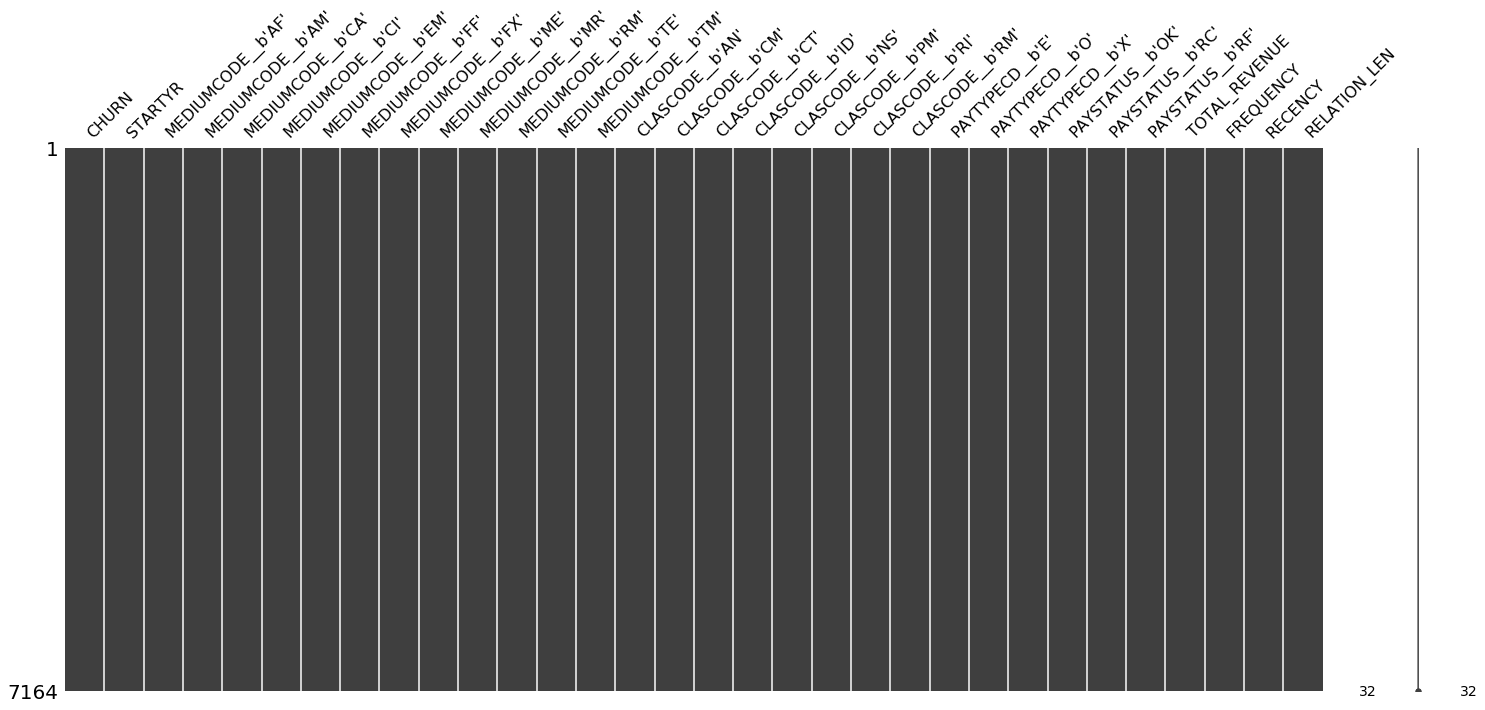

In [67]:
import missingno as mnso
mnso.matrix(final)

## Outliers Treatment

In [68]:
final= final.apply(lambda x: x.clip(x.quantile(0.01), x.quantile(0.99)))

C:\Users\Hp\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


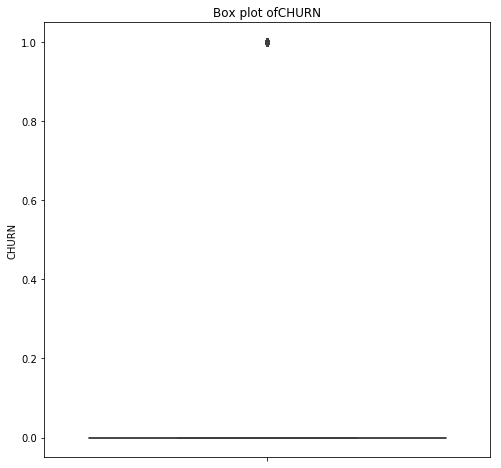

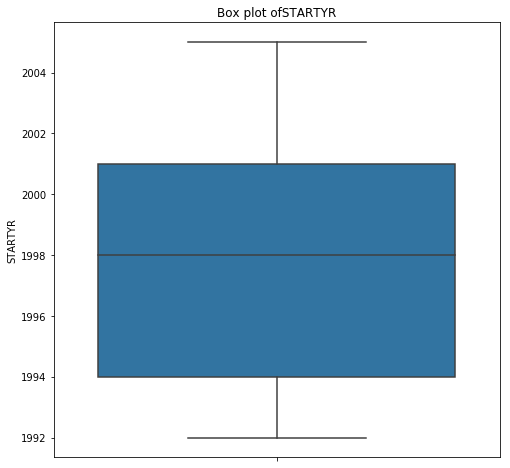

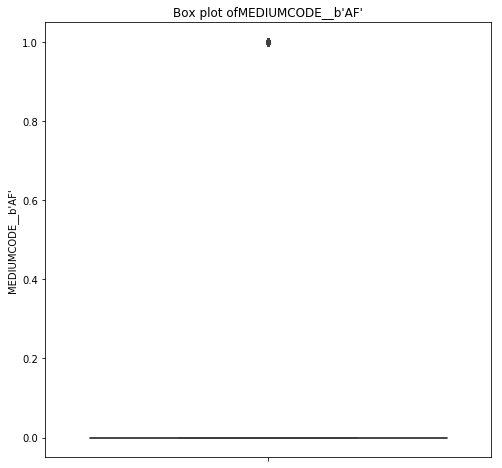

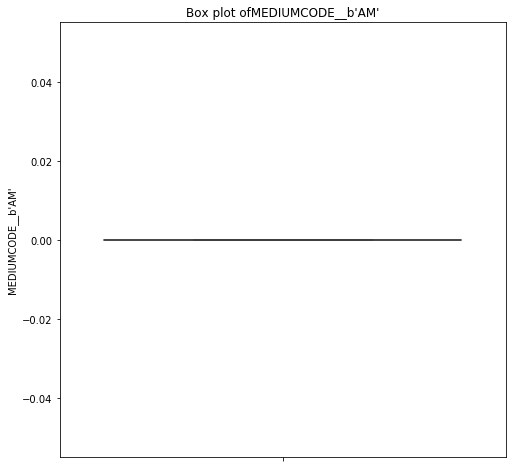

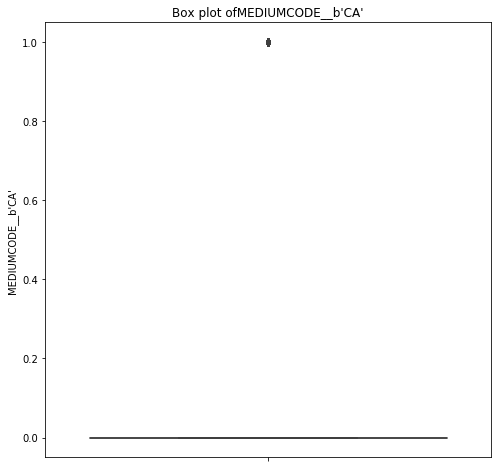

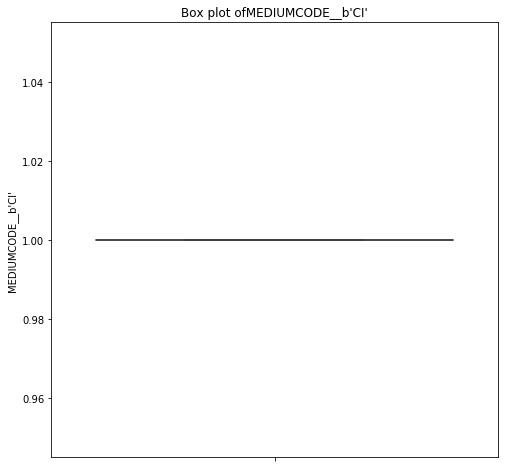

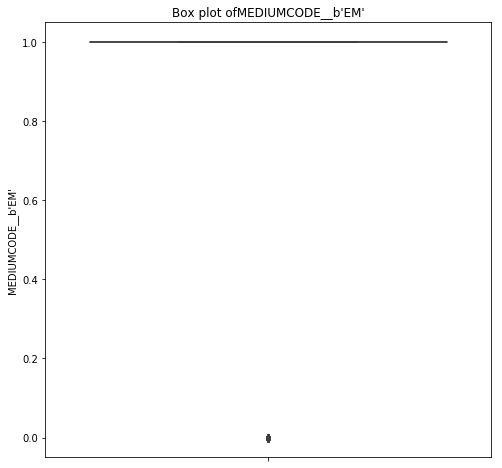

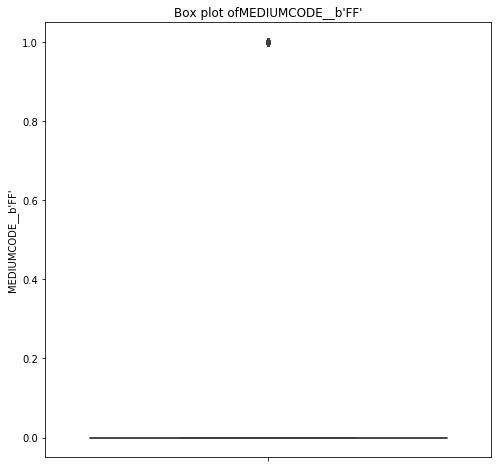

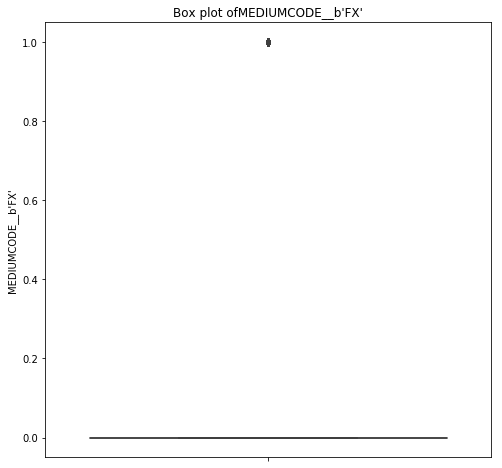

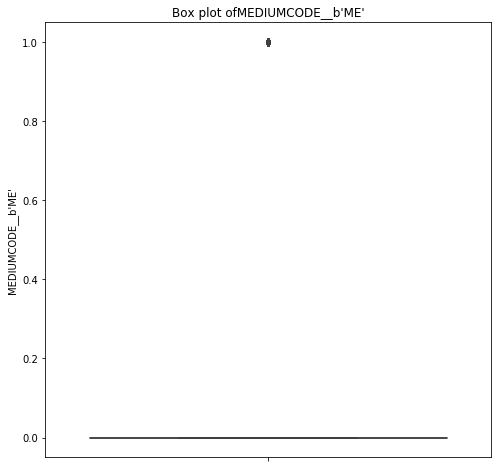

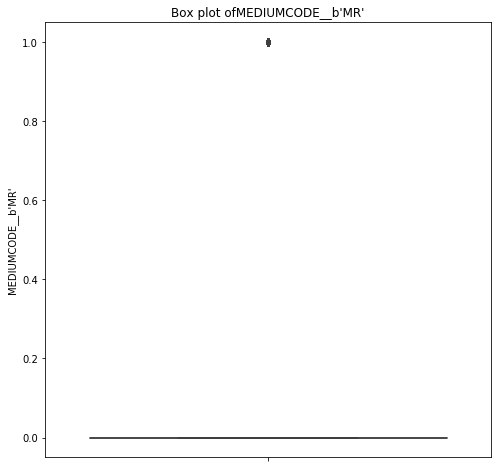

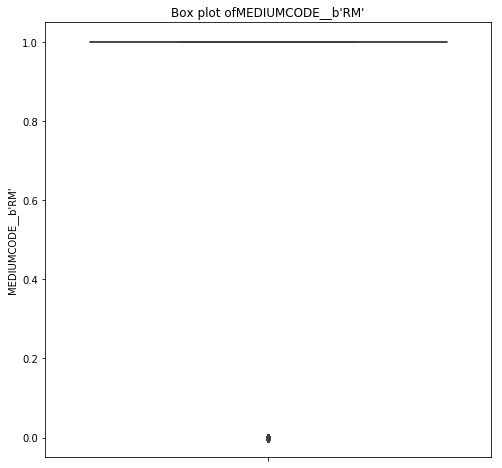

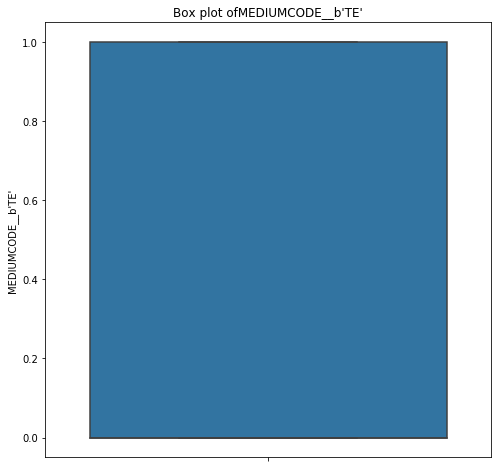

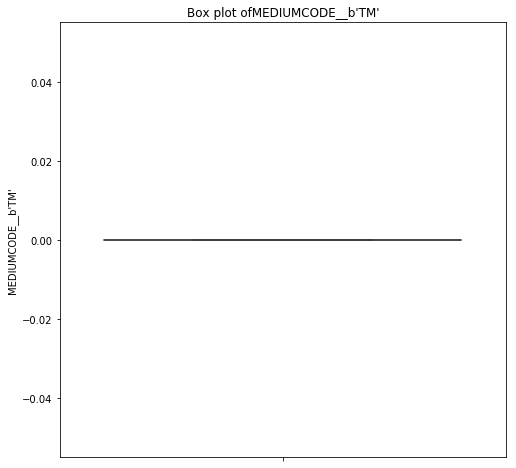

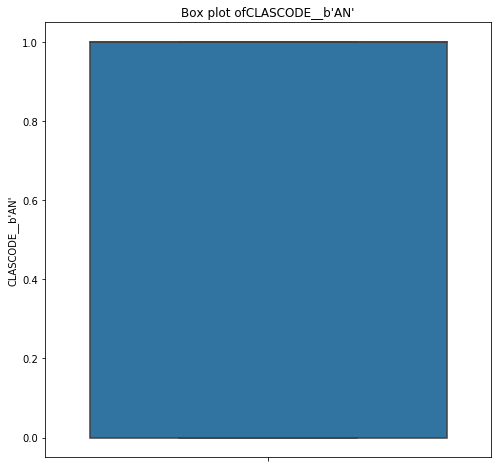

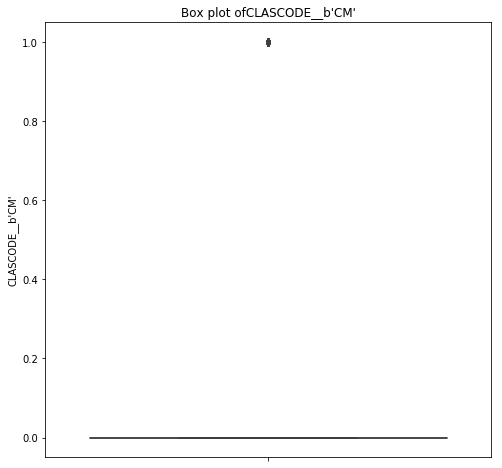

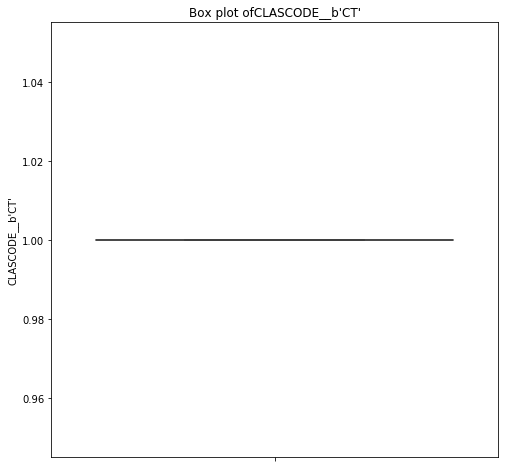

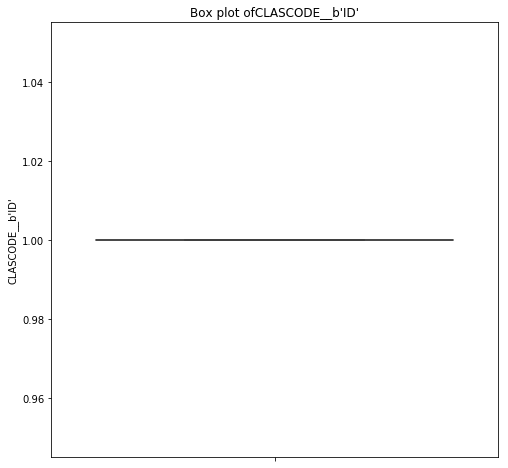

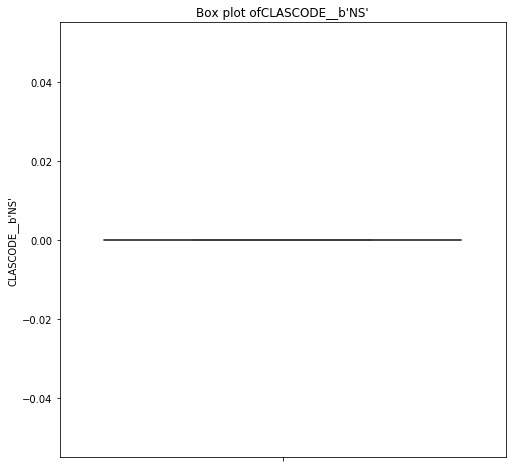

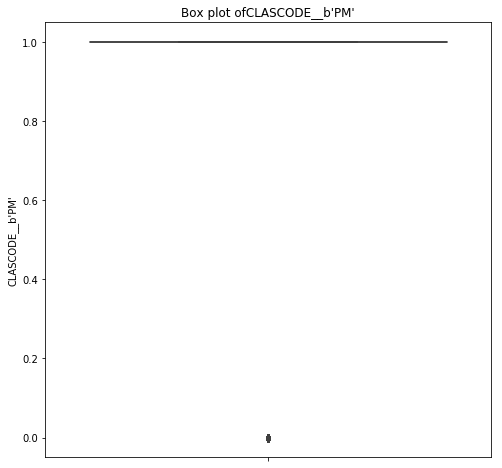

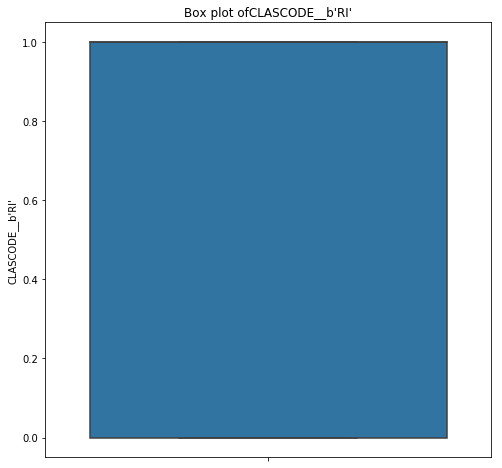

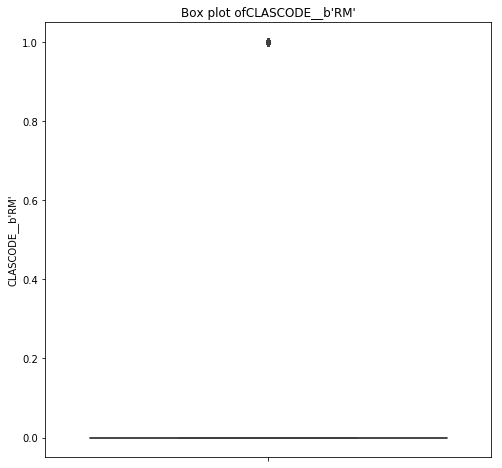

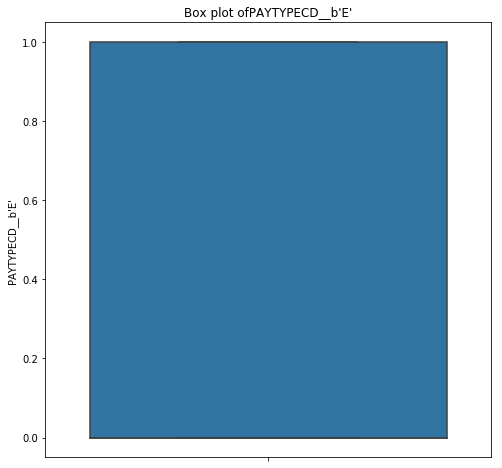

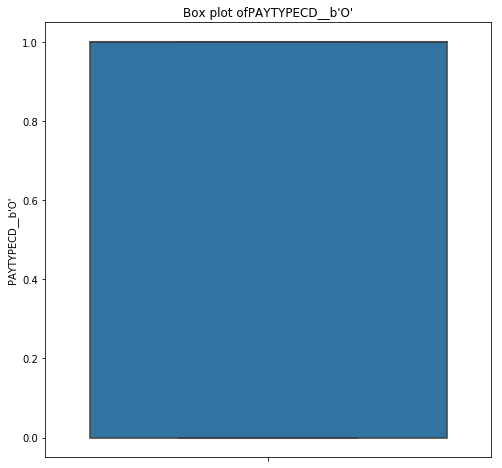

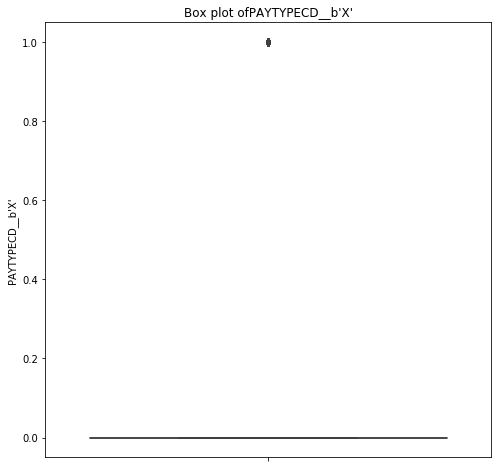

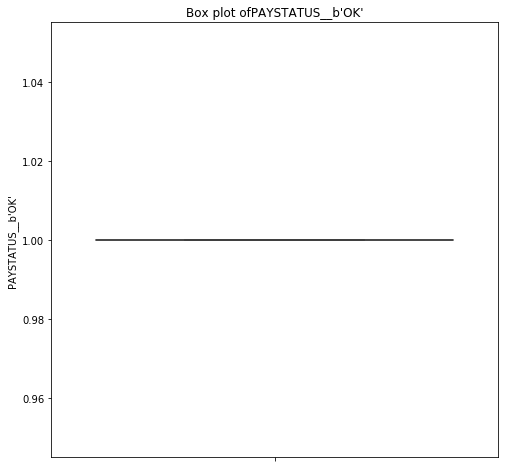

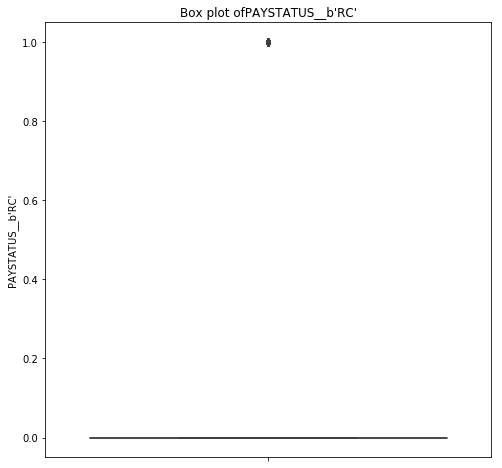

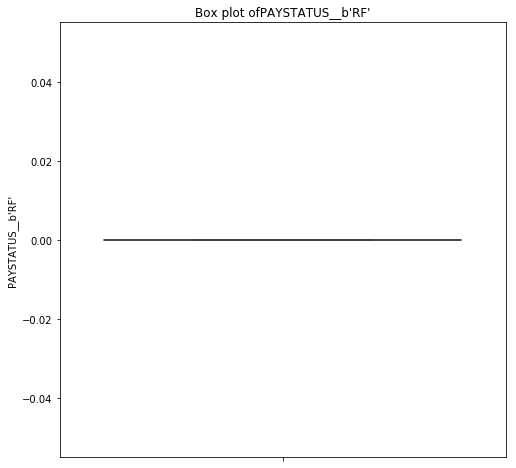

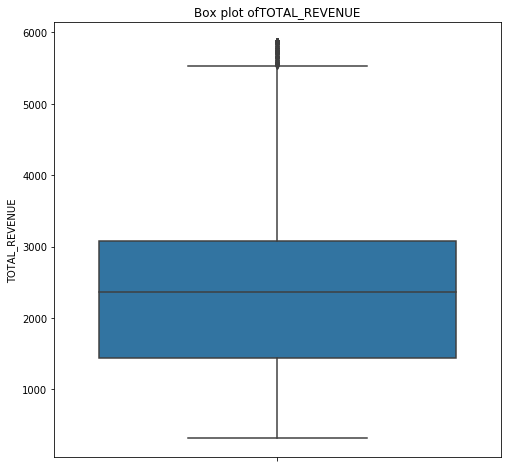

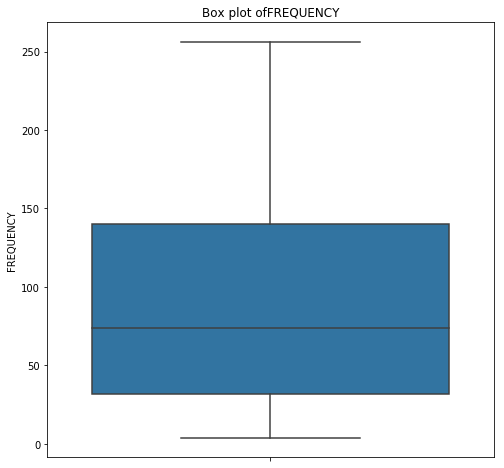

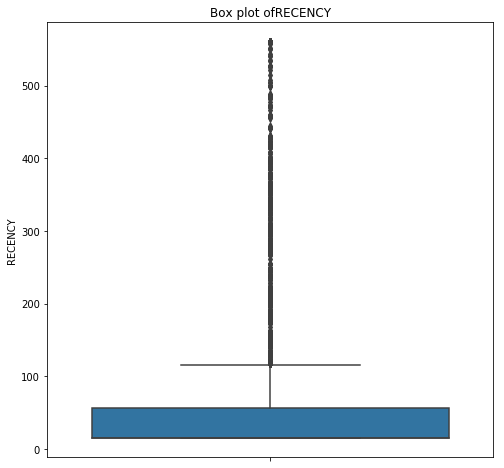

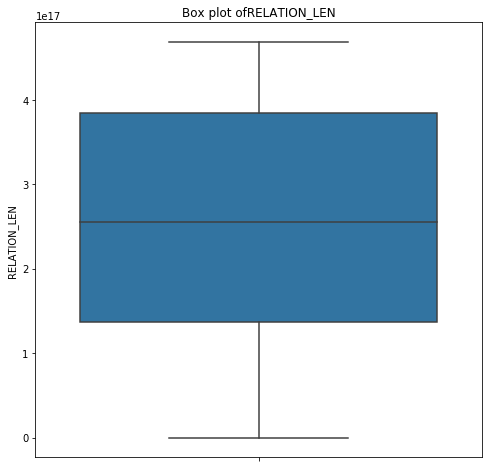

In [69]:
for col in final.columns:
    plt.figure(figsize=(8,8))
    sns.boxplot(y=col, data=final)
    plt.title(str('Box plot of') + str(col))

In [70]:
final.columns

Index(['CHURN', 'STARTYR', 'MEDIUMCODE__b'AF'', 'MEDIUMCODE__b'AM'',
       'MEDIUMCODE__b'CA'', 'MEDIUMCODE__b'CI'', 'MEDIUMCODE__b'EM'',
       'MEDIUMCODE__b'FF'', 'MEDIUMCODE__b'FX'', 'MEDIUMCODE__b'ME'',
       'MEDIUMCODE__b'MR'', 'MEDIUMCODE__b'RM'', 'MEDIUMCODE__b'TE'',
       'MEDIUMCODE__b'TM'', 'CLASCODE__b'AN'', 'CLASCODE__b'CM'',
       'CLASCODE__b'CT'', 'CLASCODE__b'ID'', 'CLASCODE__b'NS'',
       'CLASCODE__b'PM'', 'CLASCODE__b'RI'', 'CLASCODE__b'RM'',
       'PAYTYPECD__b'E'', 'PAYTYPECD__b'O'', 'PAYTYPECD__b'X'',
       'PAYSTATUS__b'OK'', 'PAYSTATUS__b'RC'', 'PAYSTATUS__b'RF'',
       'TOTAL_REVENUE', 'FREQUENCY', 'RECENCY', 'RELATION_LEN'],
      dtype='object')

In [71]:
final['ln_TOTAL_REVENUE']= np.log(final['TOTAL_REVENUE']+1)
final['ln_FREQUENCY']= np.log(final['FREQUENCY']+1)
final['ln_RECENCY']= np.log(final['RECENCY']+1)
final['ln_RELATION_LEN']= np.log(final['RELATION_LEN']+1)
final.drop(final[['TOTAL_REVENUE', 'FREQUENCY','RECENCY', 'RELATION_LEN']], axis=1, inplace=True)
final.head()

,CHURN,STARTYR,MEDIUMCODE__b'AF',MEDIUMCODE__b'AM',MEDIUMCODE__b'CA',MEDIUMCODE__b'CI',MEDIUMCODE__b'EM',MEDIUMCODE__b'FF',MEDIUMCODE__b'FX',MEDIUMCODE__b'ME',MEDIUMCODE__b'MR',MEDIUMCODE__b'RM',MEDIUMCODE__b'TE',MEDIUMCODE__b'TM',CLASCODE__b'AN',CLASCODE__b'CM',CLASCODE__b'CT',CLASCODE__b'ID',CLASCODE__b'NS',CLASCODE__b'PM',CLASCODE__b'RI',CLASCODE__b'RM',PAYTYPECD__b'E',PAYTYPECD__b'O',PAYTYPECD__b'X',PAYSTATUS__b'OK',PAYSTATUS__b'RC',PAYSTATUS__b'RF',ln_TOTAL_REVENUE,ln_FREQUENCY,ln_RECENCY,ln_RELATION_LEN
EXTRELNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b'0026419',0.0,1992.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,8.057077,4.248495,3.465736,40.68786
b'0026430',1.0,1992.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,7.932768,4.990433,6.159095,8.53405
b'0026431',0.0,1992.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,8.023425,3.091042,5.638355,40.68786
b'0026443',0.0,1992.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,8.042577,5.056246,2.833213,40.68786
b'0026444',0.0,1992.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,8.037049,5.062595,2.833213,40.68786


## Bivariate Analysis for Numerical variables- T-Stats/ P-values

In [72]:
import scipy.stats as stats
tstats_df= pd.DataFrame()
for col in ['ln_TOTAL_REVENUE', 'ln_FREQUENCY','ln_RECENCY', 'ln_RELATION_LEN']:
    tstats= stats.ttest_ind(final[final['CHURN']==1][col], final[final['CHURN']==0][col])
    temp= pd.DataFrame([col, tstats[0], tstats[1]]).T
    temp.columns=['Variable', 'T-Stats', 'P-Value']
    tstats_df= pd.concat([tstats_df, temp], axis=0)
    
tstats_df

,Variable,T-Stats,P-Value
0,ln_TOTAL_REVENUE,-8.66845,5.35533e-18
0,ln_FREQUENCY,-5.10613,3.37305e-07
0,ln_RECENCY,52.5116,0
0,ln_RELATION_LEN,-298.119,0


## Bivariate Analysis - Visualization

C:\Users\Hp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


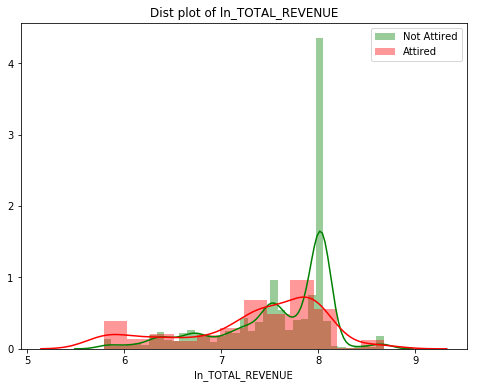

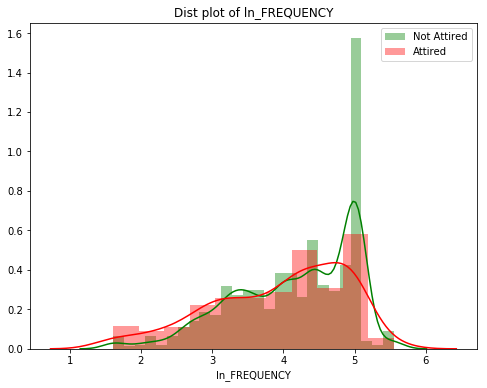

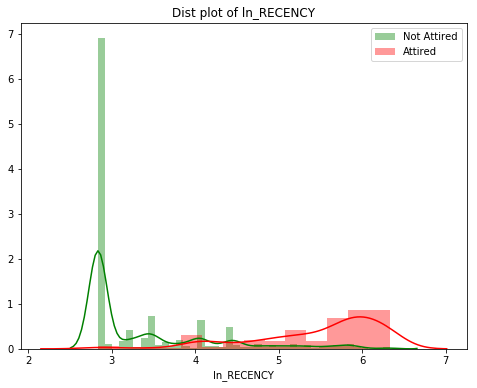

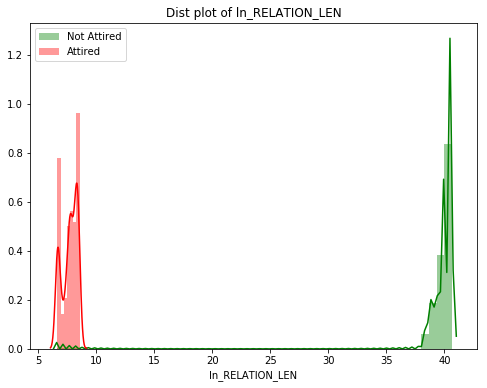

In [73]:
for col in ['ln_TOTAL_REVENUE', 'ln_FREQUENCY','ln_RECENCY', 'ln_RELATION_LEN']:
    plt.figure(figsize=(8,6))
    sns.distplot(final[final.CHURN==0][col], label='Not Attired', color= 'g')
    sns.distplot(final[final.CHURN==1][col], label='Attired', color= 'r')
    plt.legend()
    plt.title(str('Dist plot of ') + str(col))

## Exploring Multicolinearity

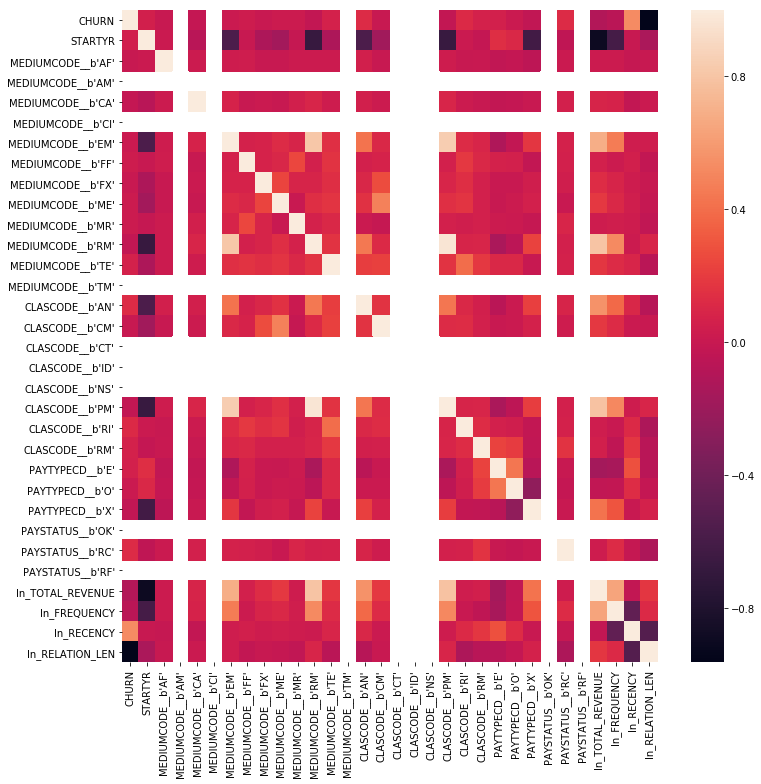

In [74]:
plt.figure(figsize=(12,12))
sns.heatmap(final.corr())

## Variable Reduction - VIF

In [75]:
new_col= final.columns
new_col= ["_".join(x.split("'")) for x in new_col]
new_col

final.rename(columns= dict(zip(final.columns, new_col)), inplace= True)

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
all_col = '+'.join(final.columns.difference(['CHURN','STARTYR']))
my_formula= 'CHURN~' + all_col

from patsy import dmatrices
y,x = dmatrices(my_formula, final, return_type='dataframe')

vif= pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif['FEATURES']= x.columns
vif.sort_values(by='VIF', ascending= False)

C:\Users\Hp\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Hp\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,FEATURES
6,17.632209,CLASCODE__b_PM_
18,15.499545,MEDIUMCODE__b_RM_
30,5.629018,ln_TOTAL_REVENUE
27,3.693965,ln_FREQUENCY
13,3.637192,MEDIUMCODE__b_EM_
28,3.287910,ln_RECENCY
29,2.000148,ln_RELATION_LEN
1,1.583998,CLASCODE__b_AN_
24,1.495799,PAYTYPECD__b_E_
26,1.454138,PAYTYPECD__b_X_


In [77]:
final.drop("MEDIUMCODE__b_RM_", axis=1, inplace=True)
all_col = '+'.join(final.columns.difference(['CHURN','STARTYR']))
my_formula= 'CHURN~' + all_col

from patsy import dmatrices
y,x = dmatrices(my_formula, final, return_type='dataframe')

vif= pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif['FEATURES']= x.columns
vif.sort_values(by='VIF', ascending= False)

C:\Users\Hp\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Hp\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,FEATURES
29,5.473553,ln_TOTAL_REVENUE
6,5.153924,CLASCODE__b_PM_
26,3.693054,ln_FREQUENCY
13,3.633014,MEDIUMCODE__b_EM_
27,3.286678,ln_RECENCY
28,2.000121,ln_RELATION_LEN
1,1.583871,CLASCODE__b_AN_
23,1.495800,PAYTYPECD__b_E_
25,1.453941,PAYTYPECD__b_X_
2,1.399772,CLASCODE__b_CM_


In [78]:
final.drop(columns=[ "CLASCODE__b_NS_", "MEDIUMCODE__b_AM_", "MEDIUMCODE__b_TM_", "PAYSTATUS__b_RF_"], axis=1, inplace=True)
all_col = '+'.join(final.columns.difference(['CHURN','STARTYR']))
my_formula= 'CHURN~' + all_col

from patsy import dmatrices
y,x = dmatrices(my_formula, final, return_type='dataframe')

vif= pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif['FEATURES']= x.columns
vif.sort_values(by='VIF', ascending= False)

C:\Users\Hp\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,FEATURES
25,5.474025,ln_TOTAL_REVENUE
5,5.153939,CLASCODE__b_PM_
22,3.693543,ln_FREQUENCY
11,3.633017,MEDIUMCODE__b_EM_
23,3.287035,ln_RECENCY
24,2.000157,ln_RELATION_LEN
1,1.583916,CLASCODE__b_AN_
19,1.496041,PAYTYPECD__b_E_
21,1.454241,PAYTYPECD__b_X_
2,1.399773,CLASCODE__b_CM_


In [79]:
final.drop("CLASCODE__b_PM_", axis=1, inplace=True)
all_col = '+'.join(final.columns.difference(['CHURN','STARTYR']))
my_formula= 'CHURN~' + all_col

from patsy import dmatrices
y,x = dmatrices(my_formula, final, return_type='dataframe')

vif= pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif['FEATURES']= x.columns
vif.sort_values(by='VIF', ascending= False)

C:\Users\Hp\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,FEATURES
24,4.527489,ln_TOTAL_REVENUE
21,3.678849,ln_FREQUENCY
22,3.268969,ln_RECENCY
10,2.056618,MEDIUMCODE__b_EM_
23,1.998019,ln_RELATION_LEN
1,1.576671,CLASCODE__b_AN_
18,1.495896,PAYTYPECD__b_E_
20,1.414380,PAYTYPECD__b_X_
2,1.398547,CLASCODE__b_CM_
19,1.384740,PAYTYPECD__b_O_


In [80]:
final.shape

(7164, 26)

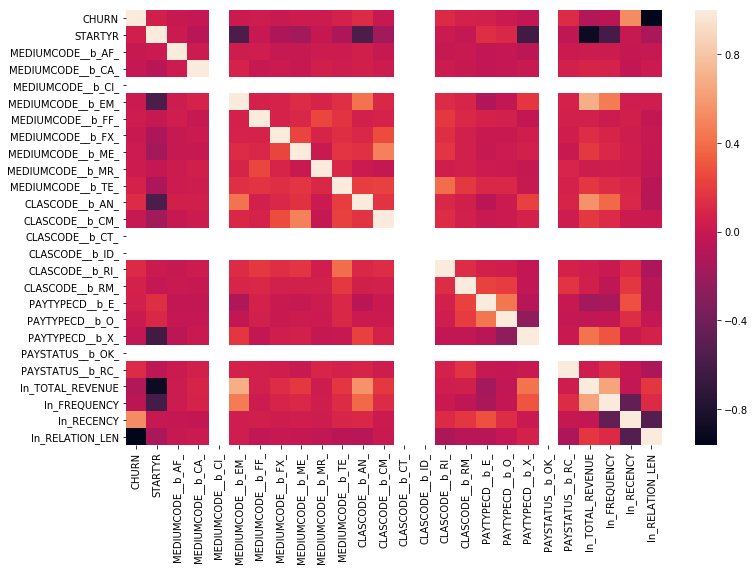

In [93]:
plt.figure(figsize=(12,8))
sns.heatmap(final.corr())

In [82]:
final.columns

Index(['CHURN', 'STARTYR', 'MEDIUMCODE__b_AF_', 'MEDIUMCODE__b_CA_',
       'MEDIUMCODE__b_CI_', 'MEDIUMCODE__b_EM_', 'MEDIUMCODE__b_FF_',
       'MEDIUMCODE__b_FX_', 'MEDIUMCODE__b_ME_', 'MEDIUMCODE__b_MR_',
       'MEDIUMCODE__b_TE_', 'CLASCODE__b_AN_', 'CLASCODE__b_CM_',
       'CLASCODE__b_CT_', 'CLASCODE__b_ID_', 'CLASCODE__b_RI_',
       'CLASCODE__b_RM_', 'PAYTYPECD__b_E_', 'PAYTYPECD__b_O_',
       'PAYTYPECD__b_X_', 'PAYSTATUS__b_OK_', 'PAYSTATUS__b_RC_',
       'ln_TOTAL_REVENUE', 'ln_FREQUENCY', 'ln_RECENCY', 'ln_RELATION_LEN'],
      dtype='object')

In [146]:
final['CHURN'].value_counts()

0.0    6702
1.0     462
Name: CHURN, dtype: int64

## Variable Selection - f_regression, p_value

In [83]:
y_df= final['CHURN']
x_df=final[['MEDIUMCODE__b_AF_', 'MEDIUMCODE__b_CA_',
       'MEDIUMCODE__b_CI_', 'MEDIUMCODE__b_EM_', 'MEDIUMCODE__b_FF_',
       'MEDIUMCODE__b_FX_', 'MEDIUMCODE__b_ME_', 'MEDIUMCODE__b_MR_',
       'MEDIUMCODE__b_TE_', 'CLASCODE__b_AN_', 'CLASCODE__b_CM_',
       'CLASCODE__b_CT_', 'CLASCODE__b_ID_', 'CLASCODE__b_RI_',
       'CLASCODE__b_RM_', 'PAYTYPECD__b_E_', 'PAYTYPECD__b_O_',
       'PAYTYPECD__b_X_', 'PAYSTATUS__b_OK_', 'PAYSTATUS__b_RC_',
       'ln_TOTAL_REVENUE', 'ln_FREQUENCY', 'ln_RECENCY', 'ln_RELATION_LEN']]

In [84]:
from sklearn.feature_selection import f_regression

f_value, p_value= f_regression(x_df, y_df)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Hp\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Hp\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Hp\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [86]:
fval= pd.DataFrame()
fval['F_VALUE']= f_value
fval['P_VALUE']= p_value.round(2)
fval['FEATURES']= x_df.columns
fval.sort_values(by='P_VALUE', ascending=False)

,F_VALUE,P_VALUE,FEATURES
0,0.005304,0.94,MEDIUMCODE__b_AF_
10,0.025261,0.87,CLASCODE__b_CM_
5,0.119202,0.73,MEDIUMCODE__b_FX_
1,1.034381,0.31,MEDIUMCODE__b_CA_
3,2.144253,0.14,MEDIUMCODE__b_EM_
16,2.407410,0.12,PAYTYPECD__b_O_
7,3.507671,0.06,MEDIUMCODE__b_MR_
6,3.808050,0.05,MEDIUMCODE__b_ME_
17,5.745388,0.02,PAYTYPECD__b_X_
4,5.694731,0.02,MEDIUMCODE__b_FF_


In [90]:
x_df1=final[[ 
       'MEDIUMCODE__b_CI_', 'MEDIUMCODE__b_FF_',
       'MEDIUMCODE__b_TE_', 'CLASCODE__b_AN_',
       'CLASCODE__b_CT_', 'CLASCODE__b_ID_', 'CLASCODE__b_RI_',
       'CLASCODE__b_RM_', 'PAYTYPECD__b_E_',
       'PAYTYPECD__b_X_', 'PAYSTATUS__b_OK_', 'PAYSTATUS__b_RC_',
       'ln_TOTAL_REVENUE', 'ln_FREQUENCY', 'ln_RECENCY', 'ln_RELATION_LEN']]

In [91]:
f_value, p_value= f_regression(x_df1, y_df)

fval= pd.DataFrame()
fval['F_VALUE']= f_value
fval['P_VALUE']= p_value.round(2)
fval['FEATURES']= x_df1.columns
fval.sort_values(by='P_VALUE', ascending=False)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Hp\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Hp\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Hp\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,F_VALUE,P_VALUE,FEATURES
1,5.694731,0.02,MEDIUMCODE__b_FF_
9,5.745388,0.02,PAYTYPECD__b_X_
2,35.284383,0.00,MEDIUMCODE__b_TE_
3,108.106768,0.00,CLASCODE__b_AN_
6,101.018917,0.00,CLASCODE__b_RI_
7,35.615152,0.00,CLASCODE__b_RM_
8,26.524216,0.00,PAYTYPECD__b_E_
11,113.880217,0.00,PAYSTATUS__b_RC_
12,75.141956,0.00,ln_TOTAL_REVENUE
13,26.072552,0.00,ln_FREQUENCY


In [95]:
x_df1.columns

Index(['MEDIUMCODE__b_CI_', 'MEDIUMCODE__b_FF_', 'MEDIUMCODE__b_TE_',
       'CLASCODE__b_AN_', 'CLASCODE__b_CT_', 'CLASCODE__b_ID_',
       'CLASCODE__b_RI_', 'CLASCODE__b_RM_', 'PAYTYPECD__b_E_',
       'PAYTYPECD__b_X_', 'PAYSTATUS__b_OK_', 'PAYSTATUS__b_RC_',
       'ln_TOTAL_REVENUE', 'ln_FREQUENCY', 'ln_RECENCY', 'ln_RELATION_LEN'],
      dtype='object')

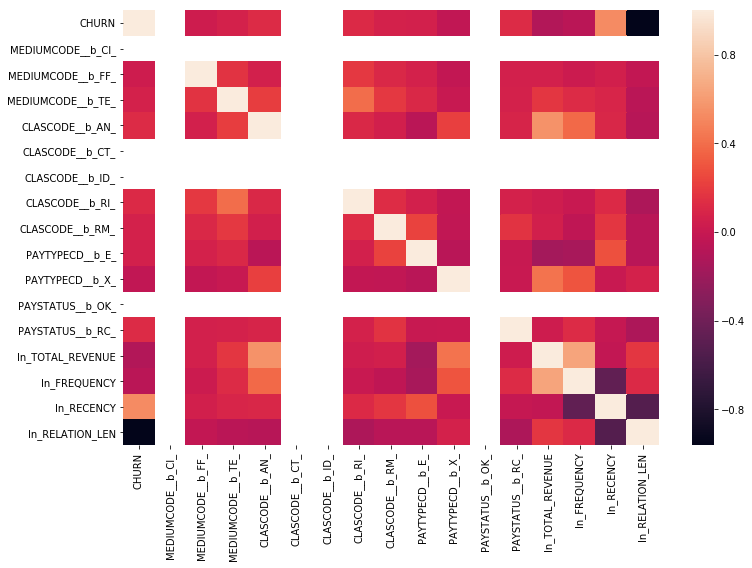

In [96]:
plt.figure(figsize=(12,8))
sns.heatmap(final[['CHURN','MEDIUMCODE__b_CI_', 'MEDIUMCODE__b_FF_', 'MEDIUMCODE__b_TE_',
       'CLASCODE__b_AN_', 'CLASCODE__b_CT_', 'CLASCODE__b_ID_',
       'CLASCODE__b_RI_', 'CLASCODE__b_RM_', 'PAYTYPECD__b_E_',
       'PAYTYPECD__b_X_', 'PAYSTATUS__b_OK_', 'PAYSTATUS__b_RC_',
       'ln_TOTAL_REVENUE', 'ln_FREQUENCY', 'ln_RECENCY', 'ln_RELATION_LEN']].corr())

In [97]:
x_df1.shape

(7164, 16)

## Splitting the Final Dataframe into Train and Test According to Specified Time Domain

In [99]:
x_train= final[final['STARTYR']<=2003].drop(['CHURN','STARTYR'], axis=1)
x_train = x_train[['MEDIUMCODE__b_CI_', 'MEDIUMCODE__b_FF_', 'MEDIUMCODE__b_TE_',
                   'CLASCODE__b_AN_', 'CLASCODE__b_CT_', 'CLASCODE__b_ID_',
                   'CLASCODE__b_RI_', 'CLASCODE__b_RM_', 'PAYTYPECD__b_E_',
                   'PAYTYPECD__b_X_', 'PAYSTATUS__b_OK_', 'PAYSTATUS__b_RC_',
                   'ln_TOTAL_REVENUE', 'ln_FREQUENCY', 'ln_RECENCY', 'ln_RELATION_LEN']]
y_train= final[final['STARTYR']<=2003]['CHURN']

x_test= final[final['STARTYR']>2003].drop(['CHURN','STARTYR'], axis=1)
x_test = x_test[['MEDIUMCODE__b_CI_', 'MEDIUMCODE__b_FF_', 'MEDIUMCODE__b_TE_',
                   'CLASCODE__b_AN_', 'CLASCODE__b_CT_', 'CLASCODE__b_ID_',
                   'CLASCODE__b_RI_', 'CLASCODE__b_RM_', 'PAYTYPECD__b_E_',
                   'PAYTYPECD__b_X_', 'PAYSTATUS__b_OK_', 'PAYSTATUS__b_RC_',
                   'ln_TOTAL_REVENUE', 'ln_FREQUENCY', 'ln_RECENCY', 'ln_RELATION_LEN']]

y_test= final[final['STARTYR']>2003]['CHURN']

In [102]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(6129, 16)
(6129,)
(1035, 16)
(1035,)


## Dealing with class imbalance Problem using SMOTE

In [103]:

from imblearn.over_sampling import SMOTE
from collections import Counter

In [104]:
sm= SMOTE(random_state= 3)

In [105]:
x_train_sm, y_train_sm= sm.fit_sample(x_train, y_train)

In [106]:
print('Before SMOTE {}'.format(Counter(y_train)))
print('After SMOTE {}'.format(Counter(y_train_sm)))

Before SMOTE Counter({0.0: 5751, 1.0: 378})
After SMOTE Counter({0.0: 5751, 1.0: 5751})


## Building Different Models For Classification

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

In [108]:
param_grid= dict(C=[.001, .01, .1, 1, 10])

In [109]:
searchgrid= GridSearchCV(estimator= LogisticRegression(), param_grid= param_grid, scoring='recall', cv=5)

In [110]:
searchgrid.fit(x_train_sm, y_train_sm)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [111]:
searchgrid.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [112]:
logreg_grid= searchgrid.best_estimator_

In [113]:
logreg_grid.fit(x_train_sm, y_train_sm)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [114]:
logreg_grid.score(x_train_sm, y_train_sm)

0.997565640758129

In [115]:
print(confusion_matrix(y_test, logreg_grid.predict(x_test)))

[[947   4]
 [  0  84]]


In [116]:
print(classification_report(y_test, logreg_grid.predict(x_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       951
         1.0       0.95      1.00      0.98        84

   micro avg       1.00      1.00      1.00      1035
   macro avg       0.98      1.00      0.99      1035
weighted avg       1.00      1.00      1.00      1035



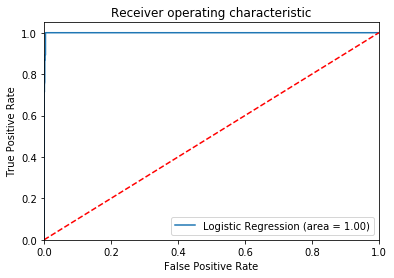

In [117]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg_grid.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_grid.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [118]:
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier(random_state= 3)
rfc.fit(x_train_sm, y_train_sm)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [119]:
rfc.score(x_train_sm, y_train_sm)

0.9998261171970092

In [120]:
y_pred= rfc.predict(x_test)

In [121]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[948   3]
 [  5  79]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       951
         1.0       0.96      0.94      0.95        84

   micro avg       0.99      0.99      0.99      1035
   macro avg       0.98      0.97      0.97      1035
weighted avg       0.99      0.99      0.99      1035



In [109]:
#param_grid= dict(n_estimators= [200, 500], max_features= ['auto', 'sqrt', 'log2'], criterion=['gini', 'entropy'])
#rfc_grid= GridSearchCV(estimator= RandomForestClassifier(), param_grid= param_grid, cv=5, scoring='recall')

In [110]:
rfc_grid= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rfc_grid.fit(x_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [111]:
#rfc_grid.best_estimator_

In [112]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train_sm, rfc_grid.predict(x_train_sm))

1.0

In [113]:
print(confusion_matrix(y_test, rfc_grid.predict(x_test)))
print(classification_report(y_test, rfc_grid.predict(x_test)))

[[947   4]
 [  3  81]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       951
         1.0       0.95      0.96      0.96        84

   micro avg       0.99      0.99      0.99      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.99      0.99      0.99      1035



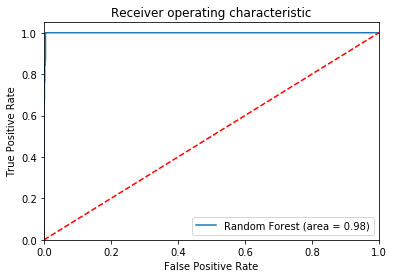

In [114]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, rfc_grid.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc_grid.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [122]:
from sklearn.svm import SVC

svc= SVC(kernel= 'linear')
svc.fit(x_train_sm, y_train_sm)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [123]:
svc.score(x_train_sm, y_train_sm)

0.997565640758129

In [124]:
print(confusion_matrix(y_test, svc.predict(x_test)))
print(classification_report(y_test, svc.predict(x_test)))

[[947   4]
 [  0  84]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       951
         1.0       0.95      1.00      0.98        84

   micro avg       1.00      1.00      1.00      1035
   macro avg       0.98      1.00      0.99      1035
weighted avg       1.00      1.00      1.00      1035



In [125]:
from sklearn.naive_bayes import GaussianNB

nbc= GaussianNB()
nbc.fit(x_train_sm, y_train_sm)

GaussianNB(priors=None, var_smoothing=1e-09)

In [126]:
nbc.score(x_train_sm, y_train_sm)

0.997565640758129

In [127]:
print(confusion_matrix(y_test, nbc.predict(x_test)))
print(classification_report(y_test, nbc.predict(x_test)))

[[947   4]
 [  0  84]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       951
         1.0       0.95      1.00      0.98        84

   micro avg       1.00      1.00      1.00      1035
   macro avg       0.98      1.00      0.99      1035
weighted avg       1.00      1.00      1.00      1035



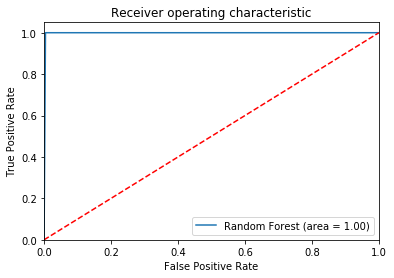

In [128]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, nbc.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, nbc.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [129]:
from sklearn import preprocessing

mscale= preprocessing.MinMaxScaler()

In [130]:
x_train_sm_scale= mscale.fit_transform(x_train_sm)
x_train_sm_scale= pd.DataFrame(x_train_sm_scale, columns= x_train.columns.tolist())


In [131]:
nbc1= GaussianNB()
nbc1.fit(x_train_sm_scale, y_train_sm)

GaussianNB(priors=None, var_smoothing=1e-09)

In [132]:
nbc1.score(x_train_sm_scale, y_train_sm)

0.997565640758129

In [133]:
x_test_scale= mscale.fit_transform(x_test)
x_test_scale= pd.DataFrame(x_test_scale, columns= x_train.columns.tolist())

In [134]:
print(confusion_matrix(y_test, nbc1.predict(x_test_scale)))
print(classification_report(y_test, nbc1.predict(x_test_scale)))

[[947   4]
 [  0  84]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       951
         1.0       0.95      1.00      0.98        84

   micro avg       1.00      1.00      1.00      1035
   macro avg       0.98      1.00      0.99      1035
weighted avg       1.00      1.00      1.00      1035



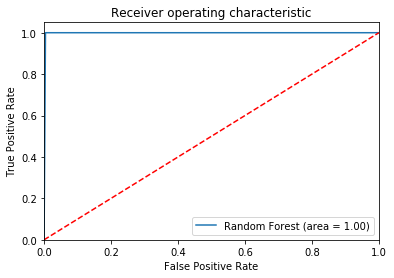

In [135]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, nbc1.predict(x_test_scale))
fpr, tpr, thresholds = roc_curve(y_test, nbc1.predict_proba(x_test_scale)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [131]:
from sklearn.model_selection import cross_val_score


sc1= cross_val_score(logreg_grid, x_train_sm, y_train_sm, cv=5, scoring='recall')
sc2= cross_val_score(rfc, x_train_sm, y_train_sm, cv=5, scoring='recall')
sc3= cross_val_score(svc, x_train_sm, y_train_sm, cv=5, scoring='recall')
sc4= cross_val_score(nbc, x_train_sm, y_train_sm, cv=5, scoring='recall')
sc5= cross_val_score(nbc1, x_train_sm_scale, y_train_sm, cv=5, scoring='recall')

l1=[]
l1.append(sc1)
l1.append(sc2)
l1.append(sc3)
l1.append(sc4)
l1.append(sc5)

l1

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

[array([1., 1., 1., 1., 1.]),
 array([0.99739357, 1.        , 1.        , 1.        , 1.        ]),
 array([1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1.])]

[Text(0, 0, 'Logistic Regression'),
 Text(0, 0, 'Random Forest'),
 Text(0, 0, 'Support Vector'),
 Text(0, 0, 'Naive Bayes'),
 Text(0, 0, 'Scaled Naive')]

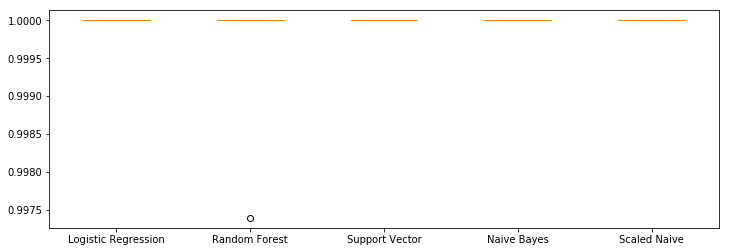

In [150]:
fig= plt.figure(figsize= (12,4))
ax= fig.add_subplot(111)
plt.boxplot(l1)
ax.set_xticklabels(['Logistic Regression','Random Forest','Support Vector','Naive Bayes','Scaled Naive'])